<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/Revision/validationForL1Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon Apr 26 18:19:03 UTC 2021


In [ ]:
#Add to CaltechData
!wget --quiet https://caltech.box.com/shared/static/wkckz5y30j9gg8z81k24046d6iq21aoq
!mv wkckz5y30j9gg8z81k24046d6iq21aoq chdA.csv.gz

!wget --quiet https://caltech.box.com/shared/static/ff8eaf930h3kcv0i662ak5p8hpstp43f
!mv ff8eaf930h3kcv0i662ak5p8hpstp43f tyr.csv.gz

!wget --quiet https://caltech.box.com/shared/static/e08icppp12mms00fi3ia9mwmrqcsie8m
!mv e08icppp12mms00fi3ia9mwmrqcsie8m chdAMeta.txt.gz

!wget --quiet https://caltech.box.com/shared/static/fa7dy54wq88bl5pjvs0037cznvzn8wus
!mv fa7dy54wq88bl5pjvs0037cznvzn8wus tyrMeta.txt.gz

In [ ]:
!gunzip *.gz

In [ ]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy==1.6.0

!pip install --quiet meld phate magic-impute cmocean diffxpy seaborn graphtools

###**Import Packages** 

In [ ]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

import meld
import phate
import magic
import scprep

import cmocean
import sklearn
import scipy
import graphtools as gt
import seaborn as sns
sns.set(style="whitegrid")

# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=14)
sc.set_figure_params(dpi=125)

# making sure plots & clusters are reproducible
np.random.seed(42)

%load_ext autoreload
%autoreload 2

import diffxpy.api as de

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import data

In [ ]:
np.random.seed(0)

sample_info = [('GSM3067201', 'chd', 'A'), ('GSM3067202', 'chd', 'B'), ('GSM3067203', 'chd', 'C'),
           ('GSM3067204', 'tyr', 'A'), ('GSM3067205', 'tyr', 'B'), ('GSM3067206', 'tyr', 'C')]
counts_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/' \
             'GSM3067nnn/{accession}/suppl/{accession}_{genotype}{replicate}' \
             '.csv.gz'
clusters_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/samples/' \
               'GSM3067nnn/{accession}/suppl/{accession}_{genotype}{replicate}_' \
               'clustID.txt.gz'
cluster_names_url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE112nnn/GSE112294/' \
                    'suppl/GSE112294_ClusterNames.csv.gz'

In [ ]:
sparse = True
counts_matrices = [] 
batch_labels = []
metadata = []
for accession, genotype, replicate in sample_info:
    curr_label = '{}{}'.format(genotype, replicate)
    print('Downloading {accession}.{genotype}.{replicate} ...'.format(accession=accession, genotype=genotype, replicate=replicate))
    
    batch_labels.append(curr_label)
    
    data = scprep.io.load_csv(counts_url.format(accession=accession, genotype=genotype, replicate=replicate),
                              sparse=sparse, cell_axis='column')
    counts_matrices.append(data)
    
    clusters = scprep.io.load_csv(clusters_url.format(accession=accession, genotype=genotype, replicate=replicate),
                       cell_names=data.index, gene_names=['clusterID'], sparse=sparse)
    metadata.append(clusters)

data, sample_labels = scprep.utils.combine_batches(counts_matrices, batch_labels, append_to_cell_names=True)
metadata, _ = scprep.utils.combine_batches(metadata, batch_labels, append_to_cell_names=True)
data.head()

Row,LOC100000009,LOC100000024,LOC100000058,LOC100000086,LOC100000094,LOC100000098,LOC100000110,LOC100000119,LOC100000140,LOC100000155,LOC100000156,LOC100000168,LOC100000205,LOC100000228,LOC100000241,LOC100000253,LOC100000275,LOC100000277,LOC100000278,LOC100000332,LOC100000352,LOC100000365,LOC100000384,LOC100000415,LOC100000417,LOC100000418,LOC100000458,LOC100000504,LOC100000545,LOC100000574,LOC100000576,LOC100000613,LOC100000627,LOC100000633,LOC100000636,LOC100000671,LOC100000675,LOC100000685,LOC100000694,LOC100000713,...,znrf1,znrf2a,znrf2b,znrf3,zp2.1,zp2.2,zp2.3,zp2.5,zp2.6,zp2l1,zp2l2,zp3,zp3.2,zp3a.1,zp3a.2,zp3b,zp3c,zpcx,zpld1a,zpr1,zranb1a,zranb1b,zranb2,zranb3,zrsr2,zswim2,zswim5,zswim6,zswim7,zswim8,zte38,zufsp,zw10,zwi,zwilch,zyg11,zymnd12,zyx,zzef1,zzz3
DEW193_TGGGAATT_AGAGACTA_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEW193_TATCTGTC_CTTCGCAC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEW193_AGGGTAAA_AAAGCCTA_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
DEW193_CCCGTTCT_GCTTTGGC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
DEW193_CCAGACAG_TGGGATTC_chdA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
counts_matrices.clear() #to save space
metadata['sample_labels'] = sample_labels
metadata.head()

,clusterID,sample_labels
DEW193_TGGGAATT_AGAGACTA_chdA,72.0,chdA
DEW193_TATCTGTC_CTTCGCAC_chdA,65.0,chdA
DEW193_AGGGTAAA_AAAGCCTA_chdA,55.0,chdA
DEW193_CCCGTTCT_GCTTTGGC_chdA,55.0,chdA
DEW193_CCAGACAG_TGGGATTC_chdA,55.0,chdA


In [ ]:
metadata['genotype'] = ['chd' if label.startswith('chd') else 'tyr' for label in metadata['sample_labels']]

In [ ]:
ClusterNamesMaps = scprep.io.load_csv(cluster_names_url, cell_names=False).set_index("ClusterID")
ClusterNamesMaps.head()

/usr/local/lib/python3.7/dist-packages/scprep/sanitize.py:51: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  RuntimeWarning,


,TimePoint(hpf),ClusterName
ClusterID,,
1.1,4,04hpf-blastocyst - EVL
1.2,4,04hpf-blastocyst - margin
1.3,4,04hpf-blastocyst - DEL
1.4,4,04hpf-blastocyst - germline
2.0,6,06hpf-non-dorsal margin


In [ ]:
#Remove days post-fert. from label
ClusterNamesMaps['ClusterName'] = ClusterNamesMaps['ClusterName'].str.slice(6)
ClusterNamesMaps.head()

,TimePoint(hpf),ClusterName
ClusterID,,
1.1,4,blastocyst - EVL
1.2,4,blastocyst - margin
1.3,4,blastocyst - DEL
1.4,4,blastocyst - germline
2.0,6,non-dorsal margin


In [ ]:
cluster_names = ClusterNamesMaps['ClusterName'].loc[metadata['clusterID']]
cluster_names.index = metadata.index
metadata['cluster'] = cluster_names
metadata.head()

,clusterID,sample_labels,genotype,cluster
DEW193_TGGGAATT_AGAGACTA_chdA,72.0,chdA,chd,hatching gland
DEW193_TATCTGTC_CTTCGCAC_chdA,65.0,chdA,chd,differentiating neurons - rohon beard
DEW193_AGGGTAAA_AAAGCCTA_chdA,55.0,chdA,chd,tailbud - PSM
DEW193_CCCGTTCT_GCTTTGGC_chdA,55.0,chdA,chd,tailbud - PSM
DEW193_CCAGACAG_TGGGATTC_chdA,55.0,chdA,chd,tailbud - PSM


Filter Genes and Cells

/usr/local/lib/python3.7/dist-packages/scprep/plot/histogram.py:167: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError
  ax.set_xscale("symlog", linthresh=abs_min)


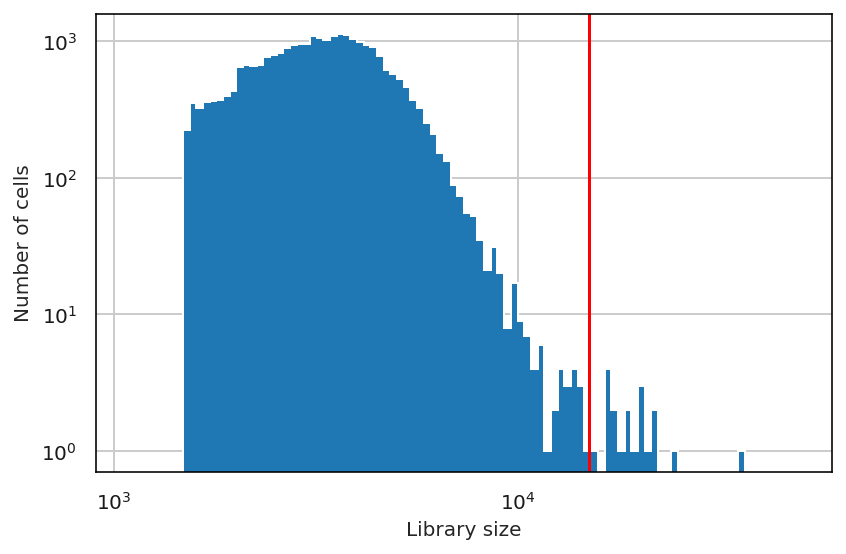

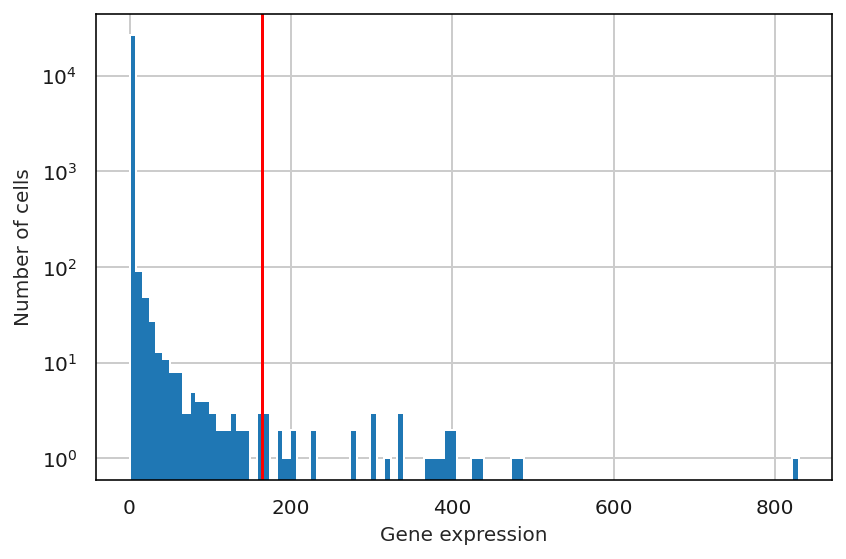

In [ ]:
data = scprep.filter.filter_rare_genes(data)

scprep.plot.plot_library_size(data, cutoff=15000);

data, metadata = scprep.filter.filter_library_size(
    data, metadata, cutoff=15000, 
    keep_cells='below')

scprep.plot.plot_gene_set_expression(data, genes=['LOC101885394'], log='y', cutoff=164)

data, metadata = scprep.filter.filter_gene_set_expression(data, metadata, genes=['LOC101885394'], cutoff=164)

In [ ]:
# Count normalization
data_libnorm, libsize = scprep.normalize.library_size_normalize(data, return_library_size=True)

metadata['library_size'] = libsize
metadata.head()

,clusterID,sample_labels,genotype,cluster,library_size
DEW193_TGGGAATT_AGAGACTA_chdA,72.0,chdA,chd,hatching gland,12786.0
DEW193_TATCTGTC_CTTCGCAC_chdA,65.0,chdA,chd,differentiating neurons - rohon beard,5267.0
DEW193_AGGGTAAA_AAAGCCTA_chdA,55.0,chdA,chd,tailbud - PSM,4438.0
DEW193_CCCGTTCT_GCTTTGGC_chdA,55.0,chdA,chd,tailbud - PSM,4054.0
DEW193_CCAGACAG_TGGGATTC_chdA,55.0,chdA,chd,tailbud - PSM,3559.0


In [ ]:
#Sqrt (vs log) transform
data_sqrt = np.sqrt(data_libnorm,dtype=np.float32)

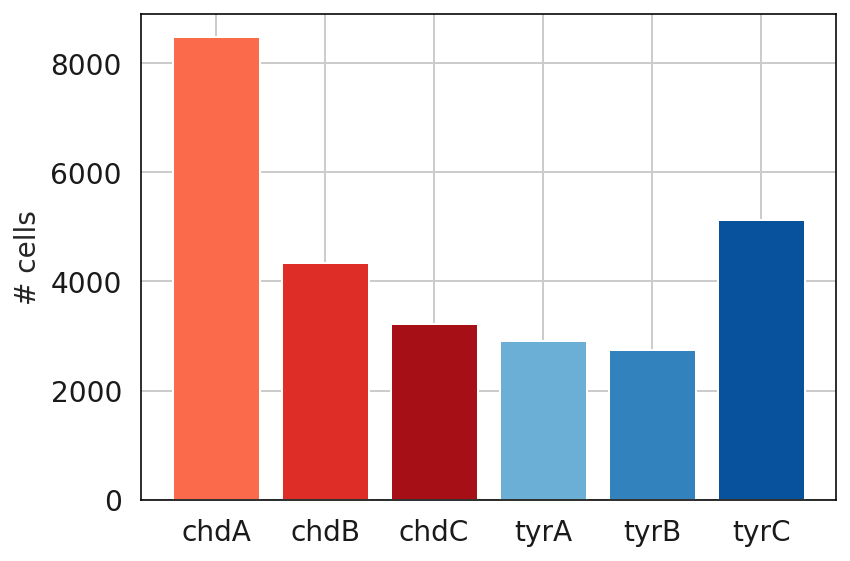

In [ ]:
sample_cmap = {'chdA' : '#fb6a4a',
                'chdB' : '#de2d26',
                'chdC' : '#a50f15',
                'tyrA' : '#6baed6',
                'tyrB' : '#3182bd',
                'tyrC' : '#08519c'}

fig, ax = plt.subplots(1)

groups, counts = np.unique(metadata['sample_labels'], return_counts=True)
for i, c in enumerate(counts):
    ax.bar(i, c, color=sample_cmap[groups[i]])
    
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(groups)
ax.set_ylabel('# cells')

fig.tight_layout()

In [ ]:
len(data_sqrt.values[,0])

29197

In [ ]:
np.unique(metadata.genotype)

array(['chd', 'tyr'], dtype=object)

### **Run L1 Analysis**

In [ ]:
#Mean center and scale
scaled = preprocessing.StandardScaler().fit_transform(data_sqrt.values)

In [ ]:
#Run scaling and PCA (100 PCs)
svd = TruncatedSVD(n_components=100,random_state=42)
pcs = svd.fit_transform(scaled)

In [ ]:
from sklearn.metrics import pairwise_distances
#Calculate centroids per condition
clus = metadata.cluster
gen = metadata.sample_labels
names = np.unique(clus)

dist = []
clust = []

perturbD = 0

centDists = pd.DataFrame()
#Within each cell type
for c in names:
  sub = pcs[clus == c,:]
  gen_sub = gen[clus == c]

#Distance between centroids of chd or tyr cells
  chdCentA = sub[gen_sub == 'chdA']#.mean(axis=0)
  chdTyrA = sub[gen_sub == 'tyrA'].mean(axis=0)

  chdCentB = sub[gen_sub == 'chdB']#.mean(axis=0)
  chdTyrB = sub[gen_sub == 'tyrB'].mean(axis=0)

  chdCentC = sub[gen_sub == 'chdC']#.mean(axis=0)
  chdTyrC = sub[gen_sub == 'tyrC'].mean(axis=0)

#Or Distances from chd cells to centroid of tyr
  chds = [chdCentA]#,chdCentB,chdCentC]
  tyrs = [chdTyrA]#,chdTyrB,chdTyrC]
  tyrLabs = ['tyrA']#,'tyrB','tyrC']

  for i in range(len(chds)):
    if tyrLabs[i] in gen_sub.to_list():
      perturbD = pairwise_distances(chds[i],tyrs[i].reshape(1, -1),metric='l1').flatten().tolist() #.flatten().tolist() #.reshape(1, -1) ,mean(axis=1)

      dist += perturbD #[np.linalg.norm(chdCent - chdTyr,1)]
      clust += [c]*len(perturbD)

centDists['Dist'] = dist
centDists['Type'] = clust
centDists.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


,Dist,Type
0,184.471009,differentiating neurons
1,195.085844,differentiating neurons
2,193.912079,differentiating neurons
3,218.558571,differentiating neurons
4,259.886606,differentiating neurons


In [ ]:
from sklearn.preprocessing import scale
centDists['DistZ'] = (centDists['Dist'] - np.min(centDists['Dist']))/np.max(centDists['Dist'])#(centDists['Dist'] - centDists['Dist'].mean()) / centDists['Dist'].std() #(centDists['Dist'] - np.min(centDists['Dist']))/np.max(centDists['Dist'])

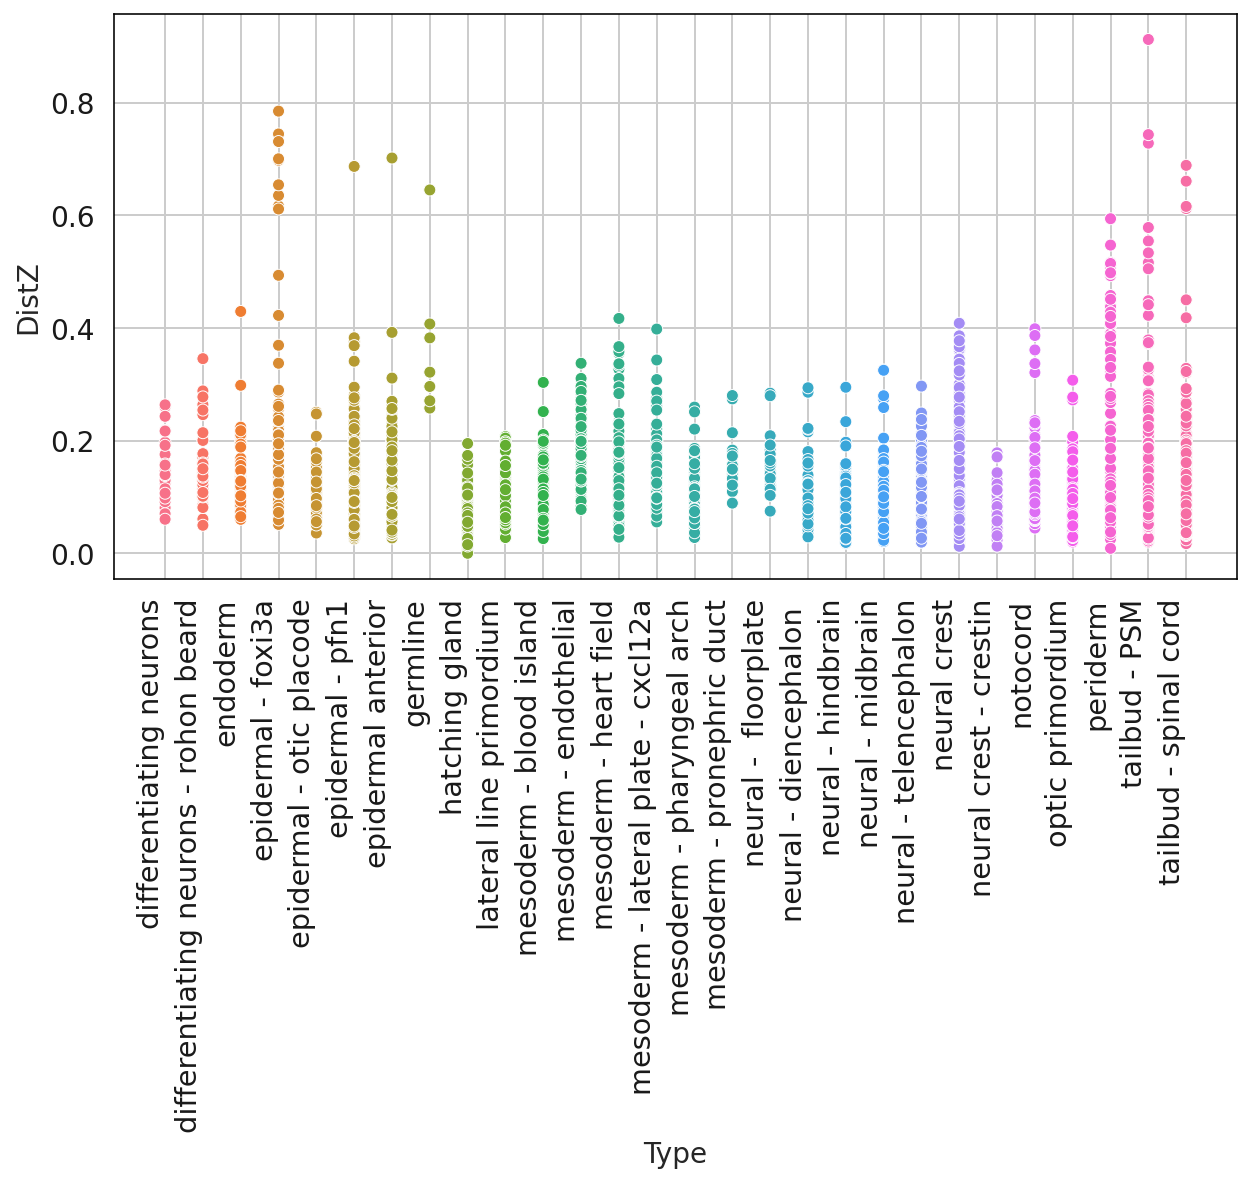

In [ ]:
plt.figure(figsize=(10,5))
s = sns.scatterplot(data=centDists, x='Type', y='DistZ', hue='Type',legend=False) #sort_values(['Dist','Type'])

plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)


plt.show()

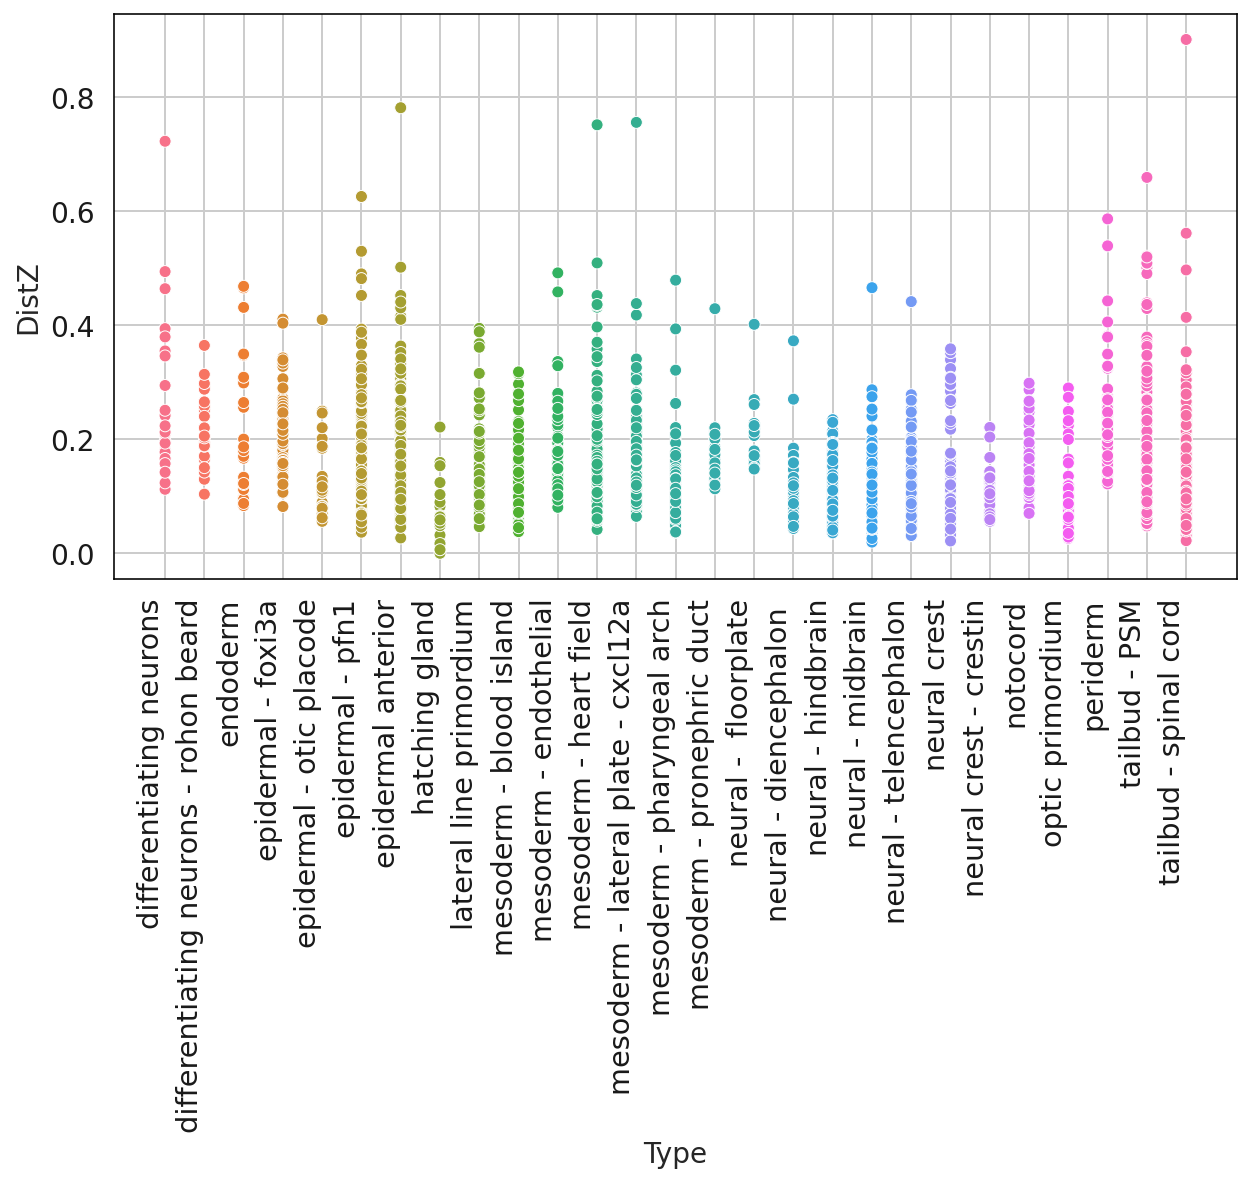

In [ ]:
plt.figure(figsize=(10,5))
s = sns.scatterplot(data=centDists, x='Type', y='DistZ', hue='Type',legend=False) #sort_values(['Dist','Type'])

plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)


plt.show()

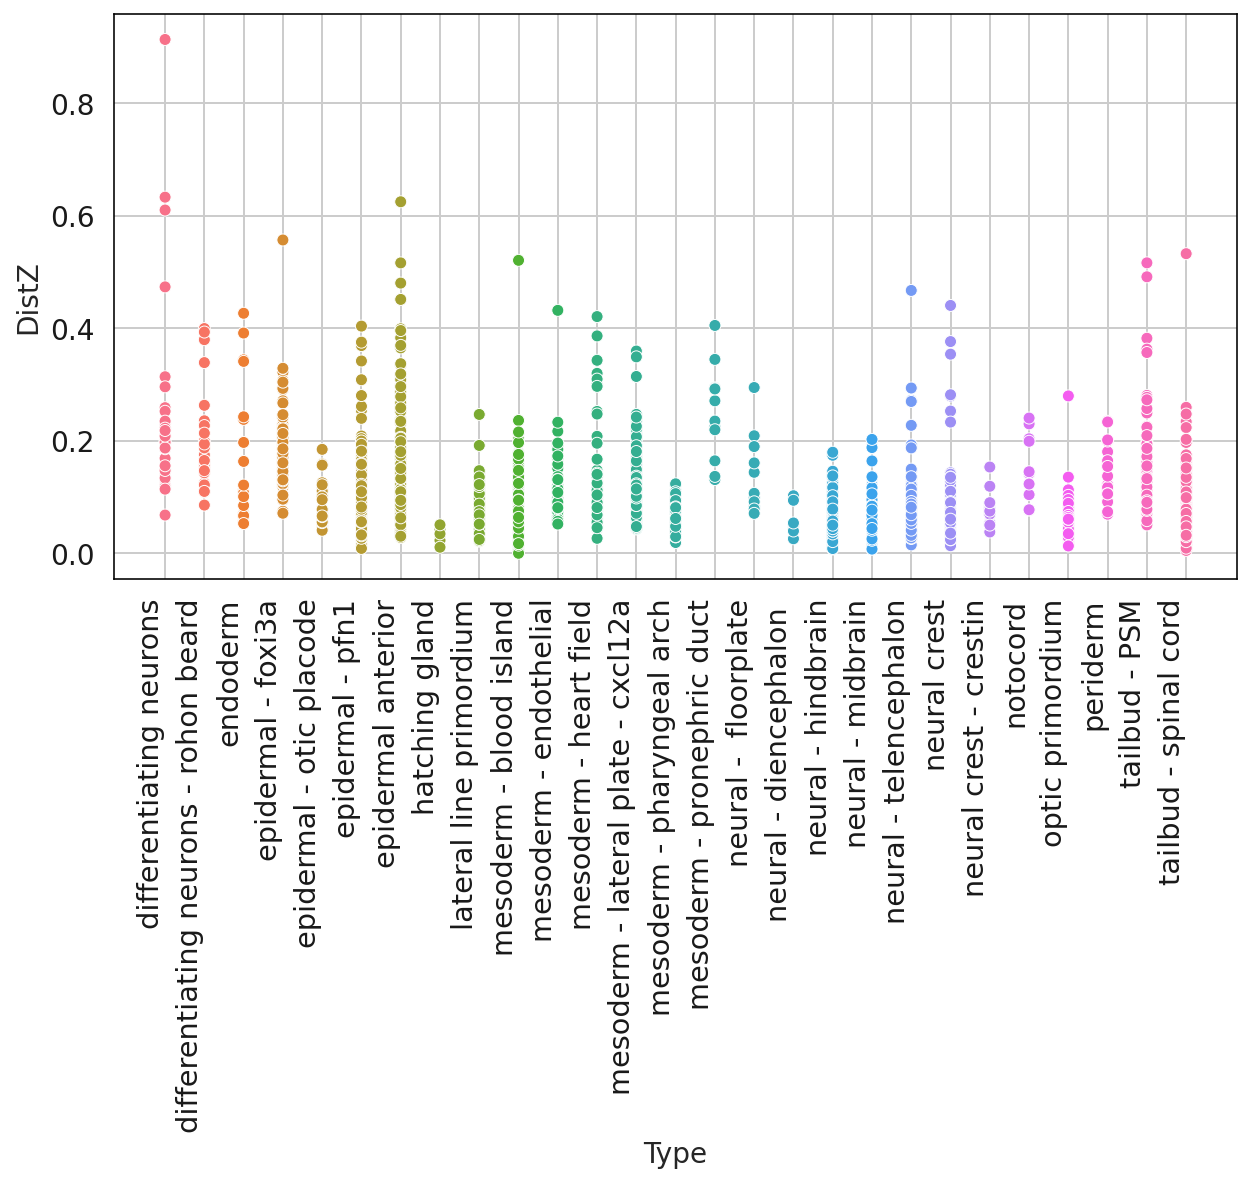

In [ ]:
plt.figure(figsize=(10,5))
s = sns.scatterplot(data=centDists, x='Type', y='DistZ', hue='Type',legend=False) #sort_values(['Dist','Type'])

plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)


plt.show()

In [ ]:
centDists.shape

(16045, 2)